In [ ]:
%%capture

!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw


## Nudged Elastic Band (NEB) 

En este tutorial emplearemos NEB para inicialmente calcular la barrera de difusión de un átomo de oro en una superficie de aluminio. Detalles del método se pueden consultar en 
[detalles](https://wiki.fysik.dtu.dk/ase/ase/neb.html)

Para rapidez en la ejecución emplearemos EMT en lugar de DFT solo por rapidez, ya que estos potenciales solo nos sirven para describir el problema. en este caso para entender el funcionamiento de la herramienta. Este notebbok se tomo del tutorial de ASE 
It is based on a [tutorial found on the ASE
[Tutorial NEB](https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial).

## Preparación de la superficie 

El primer paso es preparar la superficie, para lo cual emplearemos el paquete de ASE que nos permite construir una superficie fcc100(), este paquete toma una celda centrada en las caras y corta lo largo de la dirección 100. Adicionalmente emplearemos, la función add_adsorbate(), la cual nos permite agregar moléculas o átomos sobre superficies. 

Con lo anterior la estructura preparada queda como sigue:




In [ ]:
import matplotlib.pyplot as plt
from ase.build import fcc100, add_adsorbate
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.visualize import view
from ase.neb import NEB
from ase.io import read

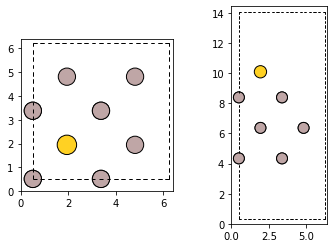

In [ ]:
import matplotlib.pyplot as plt
from ase.build import fcc100, add_adsorbate
from ase.visualize.plot import plot_atoms

# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)
fig, ax = plt.subplots(1,2)
plot_atoms(slab, ax[0], radii=0.3, rotation=('0x,0y,0z'))
plot_atoms(slab, ax[1], radii=0.3, rotation=('-90x,0y,0z'))


Ahora esta sera la posición inicial del calculo, lo que se debe hacer es relajarla y guardarla. Es importante notar que en este caso se dejaran fijas las dos ultimas capas de la superficie, es decir se relajan solo la capa superior y el átomo de oro.


In [ ]:
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS

# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
slab.set_constraint(FixAtoms(mask=mask))

# Use EMT potential:
slab.calc = EMT()

# Optimise initial state:
qn = BFGS(slab, trajectory='initial.traj')
qn.run(fmax=0.05)

[3 3 3 3 2 2 2 2 1 1 1 1 0]
      Step     Time          Energy         fmax
BFGS:    0 13:33:31        3.323870        0.2462
BFGS:    1 13:33:31        3.321365        0.2035
BFGS:    2 13:33:31        3.314740        0.0206


True

Ahora miraremos la posición final, para la cual tomamos la estructura relajada y trasladamos el átomo de oro media constante de red a lo largo del eje x. Esta estructura también la relajamos y la guardamos como estado final 


In [ ]:
# Optimise final state:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = BFGS(slab, trajectory='final.traj')
qn.run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 13:41:27        3.320046        0.1235
BFGS:    1 13:41:27        3.319145        0.1111
BFGS:    2 13:41:27        3.315607        0.0742
BFGS:    3 13:41:27        3.315469        0.0755
BFGS:    4 13:41:27        3.314645        0.0526
BFGS:    5 13:41:27        3.314491        0.0277


True

Antes  de proceder con  el  calculo  de la  barrera  grafiquemos  ambos  estados.  

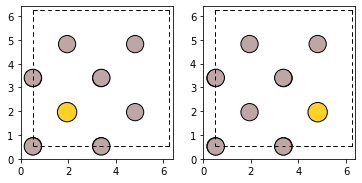

In [ ]:
from ase.io import read
initial = read('initial.traj')
final  =  read('final.traj')
fig, ax = plt.subplots(1,2)
plot_atoms(initial, ax[0], radii=0.3, rotation=('0x,0y,0z'))
plot_atoms(final, ax[1], radii=0.3, rotation=('0x,0y,0z'))

Ahora haremos el NEB con 3 imágenes entre el estado inicial y final (acá es bueno explicar en que consiste la interpolación)


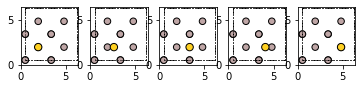

In [ ]:
from ase.neb import NEB
from ase.io import read

initial = read('initial.traj')
final = read('final.traj')

constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

n_im = 3  # number of images
images = [initial]
for i in range(n_im):
    image = initial.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

neb = NEB(images)
neb.interpolate()

fig, ax = plt.subplots(1,5)
for i  in range(5):
  plot_atoms(images[i], ax[i], radii=0.3, rotation=('0x,0y,0z'))

ahora relajamos cada una de las imágenes 


In [ ]:
qn = BFGS(neb, trajectory='neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 14:10:23        4.254555        3.6702
BFGS:    1 14:10:23        3.948627        2.2443
BFGS:    2 14:10:23        3.720944        0.4591
BFGS:    3 14:10:23        3.709881        0.2317
BFGS:    4 14:10:23        3.709137        0.2475
BFGS:    5 14:10:23        3.706433        0.2614
BFGS:    6 14:10:23        3.698860        0.2084
BFGS:    7 14:10:23        3.692303        0.2433
BFGS:    8 14:10:23        3.692326        0.1857
BFGS:    9 14:10:24        3.693528        0.1757
BFGS:   10 14:10:24        3.692720        0.1548
BFGS:   11 14:10:24        3.690856        0.0732
BFGS:   12 14:10:24        3.690226        0.0717
BFGS:   13 14:10:24        3.690413        0.0777
BFGS:   14 14:10:24        3.690469        0.1037
BFGS:   15 14:10:24        3.689938        0.1007
BFGS:   16 14:10:24        3.689053        0.0554
BFGS:   17 14:10:24        3.688740        0.0296


True


y  visualizamos  el  camino 


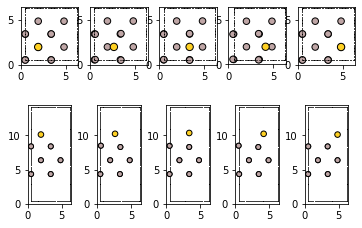

In [ ]:
fig, ax = plt.subplots(2,5)
for i  in range(5):
  plot_atoms(images[i], ax[0,i], radii=0.3, rotation=('0x,0y,0z'))
  plot_atoms(images[i], ax[1,i], radii=0.3, rotation=('-90x,0y,0z'))


Ahora la  barrera la podemos  calcular  empleando  NEBTools


In [ ]:
from ase.neb import NEBTools
import matplotlib.pyplot as plt


images = read('neb.traj@-5:')

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()
print('Barrier:', Ef)
print('Reaction energy:', dE)

Barrier: 0.37400010371564685
Reaction energy: -0.0002487861689246529


<IPython.core.display.Javascript object>

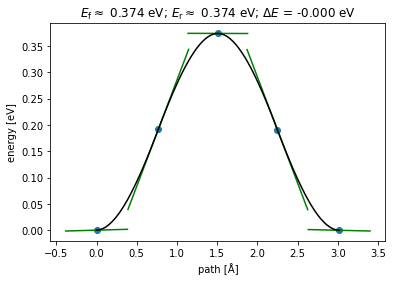

In [ ]:
import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

images = read('neb.traj@-5:')

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier(fit=False)

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
